# Quantization-Aware Training  of SpeechBrain CRDNN on GPU


This notebook provides code for quantization-aware training  of the speechbrain/asr-crdnn-rnnlm-librispeech model. We compare fine-tuned base model and quantization-aware trained model on the LibriSpeech dataset. Training is performed for two epochs.

First, we define the ASR class and write helper functions

In [57]:
import sys
import torch
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from hyperpyyaml import load_hyperpyyaml
from pathlib import Path

class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        # Forward pass
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)
        x = self.modules.enc(feats.detach())
        e_in = self.modules.emb(tokens_bos)  # y_in bos + tokens
        h, _ = self.modules.dec(e_in, x, wav_lens)

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(h)
        p_seq = self.hparams.log_softmax(logits)

        # Compute outputs
        if stage == sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch <= self.hparams.number_of_ctc_epochs:
                # Output layer for ctc log-probabilities
                logits = self.modules.ctc_lin(x)
                p_ctc = self.hparams.log_softmax(logits)
                return p_ctc, p_seq, wav_lens
            else:
                return p_seq, wav_lens
        else:
            if stage == sb.Stage.VALID:
                p_tokens, scores = self.hparams.valid_search(x, wav_lens)
            else:
                p_tokens, scores = self.hparams.test_search(x, wav_lens)
            return p_seq, wav_lens, p_tokens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        current_epoch = self.hparams.epoch_counter.current
        if stage == sb.Stage.TRAIN:
            if current_epoch <= self.hparams.number_of_ctc_epochs:
                p_ctc, p_seq, wav_lens = predictions
            else:
                p_seq, wav_lens = predictions
        else:
            p_seq, wav_lens, predicted_tokens = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        )

        # Add ctc loss if necessary
        if (
            stage == sb.Stage.TRAIN
            and current_epoch <= self.hparams.number_of_ctc_epochs
        ):
            loss_ctc = self.hparams.ctc_cost(
                p_ctc, tokens, wav_lens, tokens_lens
            )
            loss = self.hparams.ctc_weight * loss_ctc
            loss += (1 - self.hparams.ctc_weight) * loss_seq
        else:
            loss = loss_seq

        if stage != sb.Stage.TRAIN:
            # Decode token terms to words
            predicted_words = [
                self.tokenizer.decode_ids(utt_seq).split(" ")
                for utt_seq in predicted_tokens
            ]
            target_words = [wrd.split(" ") for wrd in batch.wrd]
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)

        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss):
            self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        predictions = self.compute_forward(batch, stage=stage)
        with torch.no_grad():
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(stage_stats["WER"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            if if_main_process():
                with open(self.hparams.test_wer_file, "w") as w:
                    self.wer_metric.write_stats(w)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )
    train_batch_sampler = None
    valid_batch_sampler = None
    if hparams["dynamic_batching"]:
        from speechbrain.dataio.sampler import DynamicBatchSampler  # noqa
        from speechbrain.dataio.dataloader import SaveableDataLoader  # noqa
        from speechbrain.dataio.batch import PaddedBatch  # noqa

        dynamic_hparams = hparams["dynamic_batch_sampler"]
        hop_size = dynamic_hparams["feats_hop_size"]

        num_buckets = dynamic_hparams["num_buckets"]

        train_batch_sampler = DynamicBatchSampler(
            train_data,
            dynamic_hparams["max_batch_len"],
            num_buckets=num_buckets,
            length_func=lambda x: x["duration"] * (1 / hop_size),
            shuffle=dynamic_hparams["shuffle_ex"],
            batch_ordering=dynamic_hparams["batch_ordering"],
        )

        valid_batch_sampler = DynamicBatchSampler(
            valid_data,
            dynamic_hparams["max_batch_len"],
            num_buckets=num_buckets,
            length_func=lambda x: x["duration"] * (1 / hop_size),
            shuffle=dynamic_hparams["shuffle_ex"],
            batch_ordering=dynamic_hparams["batch_ordering"],
        )

    return (
        train_data,
        valid_data,
        test_datasets,
        train_batch_sampler,
        valid_batch_sampler,
    )

## Prepare Data

In [ ]:
from datasets import load_dataset, load_metric

data = load_dataset("/home/kmb85/SpeechBrainQuant/LibriSpeech")

In [59]:
from parse_data import parse_to_json
import json
import os

parse_to_json("./LibriSpeech/dev-clean")
os.rename('data.json', 'dev-clean.json')
with open('/home/kmb85/SpeechBrainQuant/dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

parse_to_json("./LibriSpeech/test-clean")
os.rename('data.json', 'test-clean.json')
with open('/home/kmb85/SpeechBrainQuant/test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [60]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [61]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [62]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [63]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [64]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

0ex [00:00, ?ex/s]

In [65]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [66]:
data['test'] = data['test'].map(remove_special_characters_test)

0ex [00:00, ?ex/s]

## Base Model Traing

In [ ]:
hparams_file = 'hparams/train_BPE_1000_base.yaml'
run_opts = {"device":"cuda"}

In [ ]:
sb.utils.distributed.ddp_init_group(run_opts)

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, None)

sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides=None,
)

In [ ]:
from librispeech_prepare import prepare_librispeech

run_on_main(
    prepare_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "tr_splits": hparams["train_splits"],
        "dev_splits": hparams["dev_splits"],
        "te_splits": hparams["test_splits"],
        "save_folder": hparams["output_folder"],
        "merge_lst": hparams["train_splits"],
        "merge_name": "train.csv",
        "skip_prep": hparams["skip_prep"],
    },
)

In [ ]:
(
    train_data,
    valid_data,
    test_datasets,
    train_bsampler,
    valid_bsampler,
) = dataio_prepare(hparams)

In [ ]:
run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])

In [ ]:
hparams["pretrainer"]

In [ ]:
asr_brain = ASR(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

asr_brain.tokenizer = hparams["tokenizer"]
train_dataloader_opts = hparams["train_dataloader_opts"]
valid_dataloader_opts = hparams["valid_dataloader_opts"]

if train_bsampler is not None:
    train_dataloader_opts = {"batch_sampler": train_bsampler}
if valid_bsampler is not None:
    valid_dataloader_opts = {"batch_sampler": valid_bsampler}

In [ ]:
asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
)

In [1]:
# import os

# Testing
if not os.path.exists(hparams["output_wer_folder"]):
    os.makedirs(hparams["output_wer_folder"])

for k in test_datasets.keys():
    asr_brain.hparams.test_wer_file = os.path.join(
        hparams["output_wer_folder"], f"wer_{k}.txt"
    )
    asr_brain.evaluate(
        test_datasets[k],
        test_loader_kwargs=hparams["test_dataloader_opts"],
        min_key="WER",
    )


test WER: 3.23


In [ ]:
import torch
with torch.no_grad():
    features = hparams['compute_features'](torch.tensor(data['validation'][:1]['input_values']).cuda())

In [ ]:
torch.onnx.export(asr_brain.modules.enc,
     features.cuda(),
     f="asr-crdnn-librispeech-base-finetuned.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

## Quantization-Aware Training

In [67]:
hparams_file = 'hparams/train_BPE_1000_quantized.yaml'
run_opts = {"device":"cuda"}

In [ ]:
sb.utils.distributed.ddp_init_group(run_opts)

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, None)

sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides=None,
)

In [ ]:
from librispeech_prepare import prepare_librispeech

run_on_main(
    prepare_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "tr_splits": hparams["train_splits"],
        "dev_splits": hparams["dev_splits"],
        "te_splits": hparams["test_splits"],
        "save_folder": hparams["output_folder"],
        "merge_lst": hparams["train_splits"],
        "merge_name": "train.csv",
        "skip_prep": hparams["skip_prep"],
    },
)

In [70]:
(
    train_data,
    valid_data,
    test_datasets,
    train_bsampler,
    valid_bsampler,
) = dataio_prepare(hparams)

In [ ]:
run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])

asr_brain_quantized = ASR(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

asr_brain_quantized.tokenizer = hparams["tokenizer"]
train_dataloader_opts = hparams["train_dataloader_opts"]
valid_dataloader_opts = hparams["valid_dataloader_opts"]

if train_bsampler is not None:
    train_dataloader_opts = {"batch_sampler": train_bsampler}
if valid_bsampler is not None:
    valid_dataloader_opts = {"batch_sampler": valid_bsampler}

In [16]:
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [17]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [18]:
from speechbrain.pretrained import EncoderDecoderASR

model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [19]:
for name, module in model_full_quantized.mods.encoder.model.DNN.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [20]:
for name, module in model_full_quantized.mods.encoder.model.CNN.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [21]:
model_full_quantized = model_full_quantized.to('cuda')

In [22]:
import torch
with torch.no_grad():
    for i in range(2000):
            input_value = torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda")
            _ = model_full_quantized(input_value, torch.tensor([1.0]).to('cuda'))

In [23]:
# Finalize calibration

for name, module in model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

model_full_quantized = model_full_quantized.cuda()

In [24]:
asr_brain_quantized.modules.enc.DNN = model_full_quantized.mods.encoder.model.DNN
asr_brain_quantized.modules.enc.CNN = model_full_quantized.mods.encoder.model.CNN

In [ ]:
asr_brain_quantized.fit(
    asr_brain_quantized.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

In [2]:
# Testing
if not os.path.exists(hparams["output_wer_folder"]):
    os.makedirs(hparams["output_wer_folder"])

for k in test_datasets.keys():
    asr_brain_quantized.hparams.test_wer_file = os.path.join(
        hparams["output_wer_folder"], f"wer_{k}.txt"
    )
    asr_brain_quantized.evaluate(
        test_datasets[k],
        test_loader_kwargs=hparams["test_dataloader_opts"],
        min_key="WER",
    )

test WER: 3.27


In [72]:
import torch
with torch.no_grad():
    features = hparams['compute_features'](torch.tensor(data['validation'][:1]['input_values']).cuda())

In [73]:
torch.onnx.export(asr_brain_quantized.modules.enc,
     features.cuda(),
     f="asr-crdnn-librispeech-qat2.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

## Base vs Quantized Model Accuracy

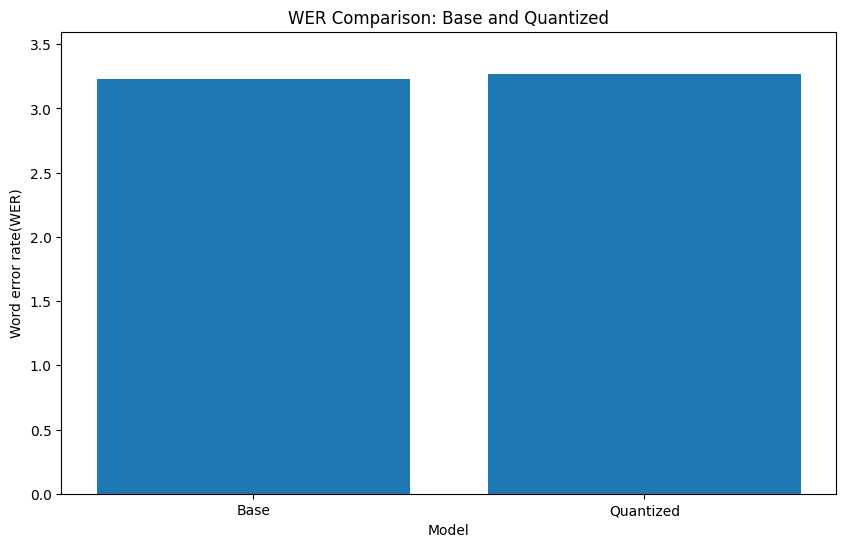

In [3]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized']
inference_times = [3.23, 3.27]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base and Quantized')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

In [4]:
percentage_diff = ((3.27 - 3.23) / 3.27) * 100
print(f'WER difference between the quantized model and the base model is {round(percentage_diff, 2)}%')

WER difference between the quantized model and the base model is 1.22%


## Base vs Quantized Model Inference Time

In [51]:
import onnxruntime as ort
ort.get_device()

'GPU'

In [52]:
ort_sess_base = ort.InferenceSession('asr-wav2vec2-librispeech-finetuned-base.onnx')
ort_sess_quantized = ort.InferenceSession('asr-crdnn-librispeech-qat.onnx', providers=['CUDAExecutionProvider'])


2024-01-10 12:32:20.600255697 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-01-10 12:32:20.600280022 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [53]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            initial_input = torch.tensor([single_batch["input_values"]]).cuda()
            features_input = hparams['compute_features'](initial_input)
            input_values = torch.tensor(features_input, device="cpu")
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [54]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [5]:
print(f'Base Fine-Tuned Model inference time {base_model_time} seconds')

Base Fine-Tuned Model inference time 0.48776673 seconds


In [ ]:
quantized_model_time = compute_inference_time(ort_sess_quantized, num_samples)

In [56]:
print(f'Quantization Aware Trained Model inference time {quantized_model_time} seconds')

Quantization Aware Trained Model inference time 0.1736392 seconds


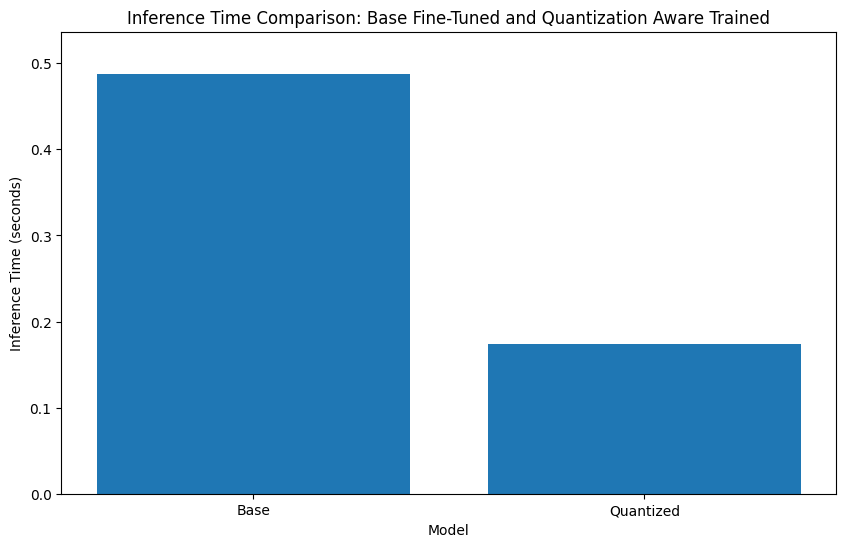

In [6]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Fine-Tuned and Quantization Aware Trained')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()